In [1]:
import tensorflow as tf
from tensorflow import keras as K
import efficientnet.keras as efn
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import itertools
import os
import shutil
import random

In [4]:

#first way to load the data
img_height = 224
img_width = 224
batch_size = 10

ds_train = tf.keras.preprocessing.image_dataset_from_directory('images',
    labels ='inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    subset = "training")

ds_validate = tf.keras.preprocessing.image_dataset_from_directory('images',
    labels ='inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.20,
    subset = "validation")

Found 7909 files belonging to 2 classes.
Using 6328 files for training.
Found 7909 files belonging to 2 classes.
Using 1581 files for validation.


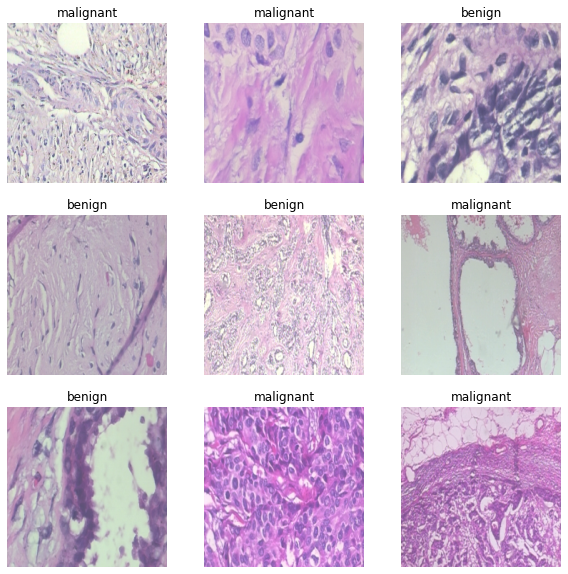

In [5]:
# Visualizing the data
class_names = ds_train.class_names

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [38]:

#Second way to load the data
#If we want the data to be broken up into Train, validation and Testing
# Change Benign and Malignant to 0 and 1 resp
os.chdir('/Users/nalisha/Documents/Winter/DepLearning/Project/images')
if os.path.isdir('train/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 2):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 788)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 394)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
            
os.chdir('../..')

In [20]:
model_o = efn.EfficientNetB0()

In [39]:
# train/valid/test - 70/20/10
train_path = '/Users/nalisha/Documents/Winter/DepLearning/Project/images/train'
valid_path = '/Users/nalisha/Documents/Winter/DepLearning/Project/images/valid'
test_path = '/Users/nalisha/Documents/Winter/DepLearning/Project/images/test'

train_batch = ImageDataGenerator(preprocessing_function = efn.preprocess_input).flow_from_directory(
    directory = train_path, target_size = (224,224), batch_size = 10)
valid_batch = ImageDataGenerator(preprocessing_function = efn.preprocess_input).flow_from_directory(
    directory = valid_path, target_size = (224,224), batch_size = 10)
test_batch = ImageDataGenerator(preprocessing_function = efn.preprocess_input).flow_from_directory(
    directory = test_path, target_size = (224,224), batch_size = 10, shuffle = False)

Found 5545 images belonging to 2 classes.
Found 1576 images belonging to 2 classes.
Found 788 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

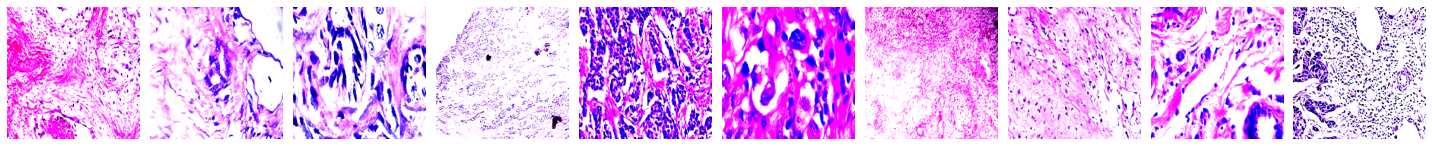

In [40]:
# Visualizing the data after the iamges were preprocessed using tf.keras.applications.mobilenet.preprocess_input
img, labels = next(train_batch)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(img)

In [10]:
model_o.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [46]:
# input the pretrained model from keras without the FC layers 
x = model_o.layers[-1].output # discarding the last 1 layers
output = Dense(units = 2, activation = 'softmax')(x) # Adding the dense layer and softmax activation
model = Model(inputs = model_o.input, outputs=output) # Making a new model
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [4]:
#pip install -U git+https://github.com/qubvel/efficientnet
#pip install --upgrade tensorflow==2.3.0
#pip install efficientnet

In [47]:
#Freezing all layers except the last 2 layers
for layer in model.layers[:-2]:
    layer.trainable = False
    
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [48]:
model.compile(optimizer = Adam(lr=0.0001), loss ='categorical_crossentropy', metrics = ['accuracy'])

In [49]:
model2 = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

In [50]:
train_features = model2.predict(train_batch)

In [52]:
print(train_features.shape)

(5545, 1280)


In [53]:
test_features = model2.predict(test_batch)
print(test_features.shape)

(788, 1280)
